# Pendekatan Big Data dengan Pyspark untuk Analisis dan Prediksi Harga Real estate di Kota Connecticut pada Tahun 2001-2021

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c6aa6aa1bd19d7007444d75763a07eb27e64580172fa23b19ac3cac59855f9ea
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Membuat SparkSession
spark = SparkSession.builder \
    .appName("RealEstatePrediction") \
    .getOrCreate()

In [ ]:
# Membaca data penjualan real estat dari file CSV
data = spark.read.csv("/content/drive/MyDrive/DataABD/Real_Estate_Sales_2001-2021_GL.csv", header=True, inferSchema=True)

In [ ]:
# Menampilkan skema data sebelum menghapus kolom dan nilai NULL
data.printSchema()

root
 |-- Serial Number: integer (nullable = true)
 |-- List Year: integer (nullable = true)
 |-- Date Recorded: string (nullable = true)
 |-- Town: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Assessed Value: double (nullable = true)
 |-- Sale Amount: double (nullable = true)
 |-- Sales Ratio: double (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Residential Type: string (nullable = true)
 |-- Non Use Code: string (nullable = true)
 |-- Assessor Remarks: string (nullable = true)
 |-- OPM remarks: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
# Menampilkan data
data.show()

+-------------+---------+-------------+----------+--------------------+--------------+-----------+-----------+-------------+----------------+------------------+--------------------+-----------+--------------------+
|Serial Number|List Year|Date Recorded|      Town|             Address|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|      Non Use Code|    Assessor Remarks|OPM remarks|            Location|
+-------------+---------+-------------+----------+--------------------+--------------+-----------+-----------+-------------+----------------+------------------+--------------------+-----------+--------------------+
|      2020348|     2020|   09/13/2021|   Ansonia|     230 WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            NULL|              NULL|                NULL|       NULL|                NULL|
|        20002|     2020|   10/02/2020|   Ashford|     390 TURNPIKE RD|      253000.0|   430000.0|     0.5883|  Residential|   Single Family

In [ ]:
# Menghapus kolom yang tidak penting
columns_to_drop = ["Serial Number", "Date Recorded", "Non Use Code", "Address", "Assessor Remarks", "OPM remarks", "Location"]
data = data.drop(*columns_to_drop)

In [ ]:
# Menghapus baris yang mengandung nilai NULL
data = data.dropna()

In [ ]:
# Menampilkan beberapa baris data
data.show(5)

+---------+-------+--------------+-----------+-----------+-------------+----------------+
|List Year|   Town|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|
+---------+-------+--------------+-----------+-----------+-------------+----------------+
|     2020|Ashford|      253000.0|   430000.0|     0.5883|  Residential|   Single Family|
|     2021|   Avon|      329730.0|   805000.0|     0.4096|  Residential|   Single Family|
|     2020|   Avon|      130400.0|   179900.0|     0.7248|  Residential|           Condo|
|     2020|   Avon|      619290.0|   890000.0|     0.6958|  Residential|   Single Family|
|     2020|   Avon|      862330.0|  1447500.0|     0.5957|  Residential|   Single Family|
+---------+-------+--------------+-----------+-----------+-------------+----------------+
only showing top 5 rows



In [ ]:
# Penanganan Outlier
def remove_outliers(df, columns):
    for column in columns:
        q1 = df.approxQuantile(column, [0.25], 0.05)[0]  # Ambil nilai pertama dari list (q1)
        q3 = df.approxQuantile(column, [0.75], 0.05)[0]  # Ambil nilai pertama dari list (q3)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return df

# Menangani outlier untuk beberapa fitur
data = remove_outliers(data, ["Assessed Value", "Sale Amount", "Sales Ratio"])

In [ ]:
# Menampilkan beberapa baris data setelah penghapusan outlier
data.show(5)

+---------+----------+--------------+-----------+-----------+-------------+----------------+
|List Year|      Town|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|
+---------+----------+--------------+-----------+-----------+-------------+----------------+
|     2020|   Ashford|      253000.0|   430000.0|     0.5883|  Residential|   Single Family|
|     2020|      Avon|      130400.0|   179900.0|     0.7248|  Residential|           Condo|
|     2021| Bethlehem|      229900.0|   561850.0|     0.4091|  Residential|   Single Family|
|     2021|Bloomfield|      111580.0|   209000.0|     0.5338|  Residential|   Single Family|
|     2020|    Bethel|      171360.0|   335000.0|     0.5115|  Residential|   Single Family|
+---------+----------+--------------+-----------+-----------+-------------+----------------+
only showing top 5 rows



In [ ]:
# Menampilkan skema data setelah penghapusan outlier
data.printSchema()

root
 |-- List Year: integer (nullable = true)
 |-- Town: string (nullable = true)
 |-- Assessed Value: double (nullable = true)
 |-- Sale Amount: double (nullable = true)
 |-- Sales Ratio: double (nullable = true)
 |-- Property Type: string (nullable = true)
 |-- Residential Type: string (nullable = true)



In [ ]:
# Mengambil kolom-kolom fitur yang relevan dan kolom target
feature_columns = ["List Year", "Town", "Assessed Value", "Sales Ratio", "Property Type", "Residential Type"]
target_column = "Sale Amount"

In [ ]:
# Mengubah kolom kategori menjadi numerik menggunakan StringIndexer dan OneHotEncoder
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index")
    for col in ["Town", "Property Type", "Residential Type"]
]

encoders = [
    OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec")
    for col in ["Town", "Property Type", "Residential Type"]
]

In [ ]:
# Penambahan Fitur
data = data.withColumn("List_Year_Assessed_Value_interaction", data["List Year"] * data["Assessed Value"])

In [ ]:
# Menggabungkan kolom-kolom fitur menjadi satu vektor fitur
assembler = VectorAssembler(
    inputCols=["List Year", "Assessed Value", "Sales Ratio"] + [col+"_vec" for col in ["Town", "Property Type", "Residential Type"]] + ["List_Year_Assessed_Value_interaction"],
    outputCol="features"
)

In [ ]:
# Membuat pipeline untuk pra-pemrosesan data
pipeline = Pipeline(stages=indexers + encoders + [assembler])

In [ ]:
# Transformasi data
data = pipeline.fit(data).transform(data)

In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Membuat model regresi linier
lr = LinearRegression(featuresCol="features", labelCol=target_column)

In [ ]:
# Melatih model regresi linier
lr_model = lr.fit(train_data)

In [ ]:
# Membuat prediksi pada data pengujian
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Sale Amount", predictionCol="prediction", metricName="rmse")
predictions_pandas = predictions.select("Sale Amount", "prediction").toPandas()

In [ ]:
predictions.select("Sale Amount", "prediction").show()

+-----------+------------------+
|Sale Amount|        prediction|
+-----------+------------------+
|    71000.0|128397.21257808525|
|   140000.0|188519.63432621118|
|   238000.0|243094.06759987306|
|   156754.0| 189041.4666857291|
|   230000.0| 239524.5323625328|
|   209000.0| 234216.9391598748|
|   166500.0|207259.97804523725|
|   195000.0|219494.34028130304|
|   205000.0|225440.35302900616|
|   210000.0|228492.08006156888|
|   210000.0|233992.99161013868|
|   275000.0|264778.61114239413|
|   198000.0|225919.19272434805|
|   268000.0| 256562.6572786672|
|   285000.0|274330.49296097737|
|   211500.0|228987.87057353184|
|   220000.0|234049.70028610434|
|   300000.0|274015.37668565754|
|   239000.0|244295.68979761004|
|   220000.0|233923.12836512458|
+-----------+------------------+
only showing top 20 rows



In [ ]:
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) pada data pengujian: {rmse}")

Root Mean Squared Error (RMSE) pada data pengujian: 29860.133660799842


In [ ]:
# Menampilkan koefisien dan intercept dari model
print(f"Koefisien: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Koefisien: [-2125.894798452069,-25.227803041522964,-292658.5390337422,-38674.744379882686,-28054.991791376695,-27454.26995327324,-24073.1646336781,-18687.05079294647,-21270.433895564576,-24878.260638275733,-35159.66048661146,-29796.01117300102,-28816.830296126027,-35939.31713137653,-33009.18524672838,-31129.161002810484,-33209.1720957728,-29450.97900251871,-29089.673528639403,-30645.685375420144,-59595.50122973576,-34494.68453387293,-32940.27427605327,-31089.68637333314,-26178.76274512949,-24564.698195711906,-33858.184854869105,-31833.635630953482,-30408.321060683014,-34065.467071845895,-25802.62576111508,-25594.74259483945,-29252.125879007788,-32097.440932478035,-32760.699015565602,-31482.80312892384,-24570.866569487367,-27841.747001268053,-24894.0893825087,-29646.90036041614,-21966.77564399747,-30562.913776677542,-22206.0231239831,-31948.12975616317,-28777.541280137422,-28574.566555221914,-19606.347106085926,-26359.20206930128,-26841.986848417288,-22651.69345113476,-28307.01113484327

In [ ]:
# Menghitung koefisien determinasi (R^2)
predictions_pandas = predictions.select("Sale Amount", "prediction").toPandas()
slope, intercept, r_value, p_value, std_err = linregress(predictions_pandas["Sale Amount"], predictions_pandas["prediction"])
print(f"Koefisien Determinasi (R^2): {r_value**2}")

Koefisien Determinasi (R^2): 0.9405484208774587


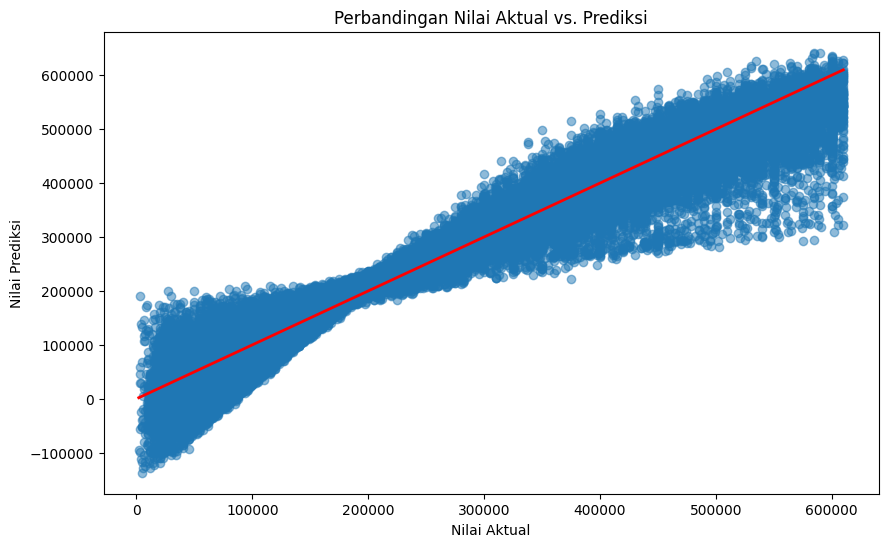

In [ ]:
# Plot Perbandingan Nilai Aktual vs. Prediksi
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["Sale Amount"], predictions_pandas["prediction"], alpha=0.5)
plt.plot([predictions_pandas["Sale Amount"].min(), predictions_pandas["Sale Amount"].max()],
         [predictions_pandas["Sale Amount"].min(), predictions_pandas["Sale Amount"].max()],
         color='red', linewidth=2)
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Perbandingan Nilai Aktual vs. Prediksi")
plt.show()

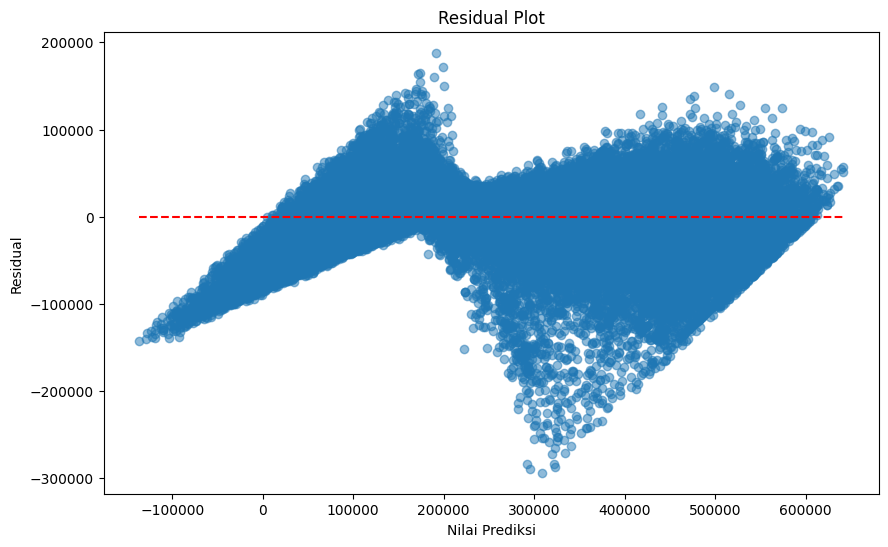

In [ ]:
# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["prediction"], predictions_pandas["prediction"] - predictions_pandas["Sale Amount"], alpha=0.5)
plt.hlines(y=0, xmin=predictions_pandas["prediction"].min(), xmax=predictions_pandas["prediction"].max(), colors='red', linestyles='dashed')
plt.xlabel("Nilai Prediksi")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

In [ ]:
# Menghentikan SparkSession
spark.stop()